## Import Libraries



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle


# Load Datasets & Quick EDA

## Challenge Dataset

In [3]:
df_challenge = pd.read_csv("/content/drive/MyDrive/Challenge Platinum/Copy of data.csv", encoding='ISO-8859-1')
pd.set_option('display.max_colwidth', None)

In [4]:
cols = df_challenge.columns[1:]

df_challenge['label'] = df_challenge[cols].any(axis=1).astype(int)
df_challenge = df_challenge.drop(columns=cols)
df_challenge.columns = ['text','label']
df_challenge['label'].replace({0:'positive', 1:'negative'}, inplace=True)
df_challenge.head()

text  \
0                                                                                                                      - disaat semua cowok berusaha melacak perhatian gue. loe lantas remehkan perhatian yg gue kasih khusus ke elo. basic elo cowok bego ! ! !'   
1                                                                                                                                        RT USER: USER siapa yang telat ngasih tau elu?edan sarap gue bergaul dengan cigax jifla calis sama siapa noh licew juga'   
2  41. Kadang aku berfikir, kenapa aku tetap percaya pada Tuhan padahal aku selalu jatuh berkali-kali. Kadang aku merasa Tuhan itu ninggalkan aku sendirian. Ketika orangtuaku berencana berpisah, ketika kakakku lebih memilih jadi Kristen. Ketika aku anak ter   
3                                                                                                                                                                                     USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT TAPI DILIAT DARI MANA ITU AKU'   
4                                                                                                                                                                       USER USER Kaum cebong kapir udah keliatan dongoknya dari awal tambah dongok lagi hahahah'   

      label  
0  negative  
1  negative  
2  positive  
3  positive  
4  negative

In [5]:
df_challenge.label.value_counts()

negative    7309
positive    5860
Name: label, dtype: int64

In [6]:
df_challenge.shape

(13169, 2)

## IndoNLU Dataset

In [7]:
df_indonlu_test = pd.read_csv("/content/drive/MyDrive/Challenge Platinum/Copy of test_preprocess.tsv", sep='\t', header= None)
df_indonlu_train = pd.read_csv("/content/drive/MyDrive/Challenge Platinum/Copy of train_preprocess.tsv", sep='\t', header= None)
df_indonlu_valid = pd.read_csv("/content/drive/MyDrive/Challenge Platinum/Copy of valid_preprocess.tsv", sep='\t', header= None)

df_indonlu = df_indonlu_train.append(df_indonlu_test, ignore_index=True)
df_indonlu = df_indonlu.append(df_indonlu_valid, ignore_index=True)
df_indonlu.columns = ['text','label']
df_indonlu = df_indonlu[df_indonlu['label']!='neutral']
df_indonlu.head()

text  \
0  warung ini dimiliki oleh pengusaha pabrik tahu yang sudah puluhan tahun terkenal membuat tahu putih di bandung . tahu berkualitas , dipadu keahlian memasak , dipadu kretivitas , jadilah warung yang menyajikan menu utama berbahan tahu , ditambah menu umum lain seperti ayam . semuanya selera indonesia . harga cukup terjangkau . jangan lewatkan tahu bletoka nya , tidak kalah dengan yang asli dari tegal !   
2                                                                                                                                                                                                                              lokasi strategis di jalan sumatera bandung . tempat nya nyaman terutama sofa di lantai 2 . paella nya enak , sangat pas dimakan dengan minum bir dingin . appetiser nya juga enak-enak .   
3                                                                                                                                                                                                                                                                                                                         betapa bahagia nya diri ini saat unboxing paket dan barang nya bagus ! menetapkan beli lagi !   
4                                                                                                                                                                                                duh . jadi mahasiswa jangan sombong dong . kasih kartu kuning segala . belajar dulu yang baik , tidak usahlah ikut-ikut politik . nanti sudah selesai kuliah nya mau ikut politik juga tidak telat . dasar mahasiswa .   
5                                                                                                                                                                                                                                                     makanan beragam , harga makanan di food stall akan ditambahkan 10 % lagi di kasir , suasana ramai dan perlu perhatian untuk mendapatkan parkir dan tempat duduk .   

      label  
0  positive  
2  positive  
3  positive  
4  negative  
5  positive

In [8]:
df_indonlu.label.value_counts()

positive    7359
negative    4034
Name: label, dtype: int64

In [9]:
df_indonlu.shape

(11393, 2)

## Challenge + Indonlu Dataset

In [10]:
df_gabung = df_indonlu.append(df_challenge, ignore_index=True)
df_gabung.head(10)

text  \
0  warung ini dimiliki oleh pengusaha pabrik tahu yang sudah puluhan tahun terkenal membuat tahu putih di bandung . tahu berkualitas , dipadu keahlian memasak , dipadu kretivitas , jadilah warung yang menyajikan menu utama berbahan tahu , ditambah menu umum lain seperti ayam . semuanya selera indonesia . harga cukup terjangkau . jangan lewatkan tahu bletoka nya , tidak kalah dengan yang asli dari tegal !   
1                                                                                                                                                                                                                              lokasi strategis di jalan sumatera bandung . tempat nya nyaman terutama sofa di lantai 2 . paella nya enak , sangat pas dimakan dengan minum bir dingin . appetiser nya juga enak-enak .   
2                                                                                                                                                                                                                                                                                                                         betapa bahagia nya diri ini saat unboxing paket dan barang nya bagus ! menetapkan beli lagi !   
3                                                                                                                                                                                                duh . jadi mahasiswa jangan sombong dong . kasih kartu kuning segala . belajar dulu yang baik , tidak usahlah ikut-ikut politik . nanti sudah selesai kuliah nya mau ikut politik juga tidak telat . dasar mahasiswa .   
4                                                                                                                                                                                                                                                     makanan beragam , harga makanan di food stall akan ditambahkan 10 % lagi di kasir , suasana ramai dan perlu perhatian untuk mendapatkan parkir dan tempat duduk .   
5                                                                                                                                                                                                                                                                                                                                                                  pakai kartu kredit bca tidak untung malah rugi besar   
6                                                                                                                                                                                   tempat unik , bagus buat foto , makanan enak , pegawai ramah , bersih dan luas , wifi kencang . harga standar dan sesuai dengan tempat nya . ada menu masakan makanan barat dan indonesia . menu favorit lychee mojito dan spagheti   
7               saya bersama keluarga baru saja menikmati pengalaman kuliner yang menyenangkan di rm sari sunda di jalan . setiabudhi , bandung . tapi , karena tidak ada hubungan untuk rm sari sunda di jalan . setiabudhi , maka saya tuliskan di sini . jadi , maaf jika rekan-rekan pembaca ada yang bingung . beberapa hal yang saya suka dari restoran ini adalah bahwa pelayanan restoran ini terbilang cepat .   
8                                                                                                                                                                                                                                                                                                                                                                                                             bersyukur   
9                                                                                                                                                                                                                                                                                                    

In [11]:
df_gabung.shape

(24562, 2)

# Data Cleansing

In [12]:
df1 = df_challenge.copy()
df2 = df_indonlu.copy()
df3 = df_gabung.copy()

In [13]:
def clean_text(text):

  # Memisahkan kata-kata setelah hashtag yang tersambung
  pattern = r"#([A-Z][a-z0-9]+)([A-Z][a-z0-9]+)"
  text = re.sub(pattern, r"# \1 \2", text)

  # Mengubah semua huruf menjadi huruf kecil
  text = text.lower()

  # Menghapus spasi di awal dan akhir text
  text = text.strip()

  # Menghapus kata 'user', 'rt', 'amp' dan 'x..'
  text = re.sub(r'\buser\b|\bRT\b|\bamp\b|(\bx[\da-f]{2})', ' ', text, flags=re.IGNORECASE)

  # Menghapus kata '\n'
  text = re.sub(r'\\n', ' ', text, flags=re.IGNORECASE)

  # Menghapus karakter non-alfanumerik
  text = re.sub(r'\W+', ' ', text)

  # Menghapus karakter berulang
  text = re.sub(r'(.)\1+', r'\1', text)

  # Menghapus karakter 'ø', 'ù', 'º', 'ð', dan lainnya
  text = re.sub(r'[øùºðµ¹ª³]', '', text, flags=re.IGNORECASE)
  text = re.sub(r'â', 'a', text, flags=re.IGNORECASE)

  # Menghapus spasi berlebih dengan mengganti beberapa spasi menjadi satu spasi
  text = re.sub(r'\s+', ' ', text).strip()

  # Menghapus seluruh kalimat yang hanya berisi spasi
  text = re.sub(r'^\s+$', '', text)

  return text

In [14]:
df1['text'] = df1['text'].apply(clean_text)
df2['text'] = df2['text'].apply(clean_text)
df3['text'] = df3['text'].apply(clean_text)

In [15]:
df1.head()

text  \
0                                                                                                                          disat semua cowok berusaha melacak perhatian gue loe lantas remehkan perhatian yg gue kasih khusus ke elo basic elo cowok bego   
1                                                                                                                                               siapa yang telat ngasih tau elu edan sarap gue bergaul dengan cigax jifla calis sama siapa noh licew juga   
2  41 kadang aku berfikir kenapa aku tetap percaya pada tuhan padahal aku selalu jatuh berkali kali kadang aku merasa tuhan itu ningalkan aku sendirian ketika orangtuaku berencana berpisah ketika kakaku lebih memilih jadi kristen ketika aku anak ter   
3                                                                                                                                                                                           aku itu aku ku tau matamu sipit tapi diliat dari mana itu aku   
4                                                                                                                                                                          kaum cebong kapir udah keliatan dongoknya dari awal tambah dongok lagi hahahah   

      label  
0  negative  
1  negative  
2  positive  
3  positive  
4  negative

In [16]:
df2.head()

text  \
0  warung ini dimiliki oleh pengusaha pabrik tahu yang sudah puluhan tahun terkenal membuat tahu putih di bandung tahu berkualitas dipadu keahlian memasak dipadu kretivitas jadilah warung yang menyajikan menu utama berbahan tahu ditambah menu umum lain seperti ayam semuanya selera indonesia harga cukup terjangkau jangan lewatkan tahu bletoka nya tidak kalah dengan yang asli dari tegal   
2                                                                                                                                                                                                                      lokasi strategis di jalan sumatera bandung tempat nya nyaman terutama sofa di lantai 2 paela nya enak sangat pas dimakan dengan minum bir dingin apetiser nya juga enak enak   
3                                                                                                                                                                                                                                                                                                          betapa bahagia nya diri ini sat unboxing paket dan barang nya bagus menetapkan beli lagi   
4                                                                                                                                                                                          duh jadi mahasiswa jangan sombong dong kasih kartu kuning segala belajar dulu yang baik tidak usahlah ikut ikut politik nanti sudah selesai kuliah nya mau ikut politik juga tidak telat dasar mahasiswa   
5                                                                                                                                                                                                                                           makanan beragam harga makanan di fod stal akan ditambahkan 10 lagi di kasir suasana ramai dan perlu perhatian untuk mendapatkan parkir dan tempat duduk   

      label  
0  positive  
2  positive  
3  positive  
4  negative  
5  positive

In [17]:
df3.head()

text  \
0  warung ini dimiliki oleh pengusaha pabrik tahu yang sudah puluhan tahun terkenal membuat tahu putih di bandung tahu berkualitas dipadu keahlian memasak dipadu kretivitas jadilah warung yang menyajikan menu utama berbahan tahu ditambah menu umum lain seperti ayam semuanya selera indonesia harga cukup terjangkau jangan lewatkan tahu bletoka nya tidak kalah dengan yang asli dari tegal   
1                                                                                                                                                                                                                      lokasi strategis di jalan sumatera bandung tempat nya nyaman terutama sofa di lantai 2 paela nya enak sangat pas dimakan dengan minum bir dingin apetiser nya juga enak enak   
2                                                                                                                                                                                                                                                                                                          betapa bahagia nya diri ini sat unboxing paket dan barang nya bagus menetapkan beli lagi   
3                                                                                                                                                                                          duh jadi mahasiswa jangan sombong dong kasih kartu kuning segala belajar dulu yang baik tidak usahlah ikut ikut politik nanti sudah selesai kuliah nya mau ikut politik juga tidak telat dasar mahasiswa   
4                                                                                                                                                                                                                                           makanan beragam harga makanan di fod stal akan ditambahkan 10 lagi di kasir suasana ramai dan perlu perhatian untuk mendapatkan parkir dan tempat duduk   

      label  
0  positive  
1  positive  
2  positive  
3  negative  
4  positive

### Duplicate Handling

In [18]:
print(df1.duplicated().sum(), df2.duplicated().sum(), df3.duplicated().sum())

276 73 350


In [19]:
df1.drop_duplicates(inplace=True)
df2.drop_duplicates(inplace=True)
df3.drop_duplicates(inplace=True)

In [20]:
print(df1.duplicated().sum(), df2.duplicated().sum(), df3.duplicated().sum())

0 0 0


### Null Value Handling

In [21]:
print(df1.isnull().sum(), df2.isnull().sum(), df3.isnull().sum())

text     0
label    0
dtype: int64 text     0
label    0
dtype: int64 text     0
label    0
dtype: int64


# EDA

## Proporsi Label Positif dan Negatif

### Dataset Challenge

In [22]:
sentiment_counts = df1['label'].value_counts().sort_index()

sentiment_labels = ['positive', 'negative']
sentiment_colors = ['red', 'lime']

total_data = sentiment_counts.sum()

fig = go.Figure(data=[go.Pie(labels=sentiment_counts.index,
                             values=sentiment_counts.values,
                             textinfo='percent+value+label',
                             marker_colors=sentiment_colors,
                             textposition='auto',
                             hole=.3)])

fig.update_layout(
    title_text='Sentiment Distribution: Dataset Challenge',
    template='plotly_white',
    xaxis=dict(
        title='Sources',
    ),
    yaxis=dict(
        title='Number of Posts in Twitter',
    )
)

fig.update_traces(marker_line_color='black',
                  marker_line_width=1.5,
                  opacity=0.8)

fig.add_annotation(text=f"Total Data: {total_data}",
                   x=0.5,
                   y=-0.2,
                   showarrow=False,
                   font=dict(size=14, color="black"))


fig.show()

### Dataset Indonlu

In [23]:
sentiment_counts = df2['label'].value_counts().sort_index()

sentiment_labels = ['positive', 'negative']
sentiment_colors = ['red', 'lime']

total_data = sentiment_counts.sum()

fig = go.Figure(data=[go.Pie(labels=sentiment_counts.index,
                             values=sentiment_counts.values,
                             textinfo='percent+value+label',
                             marker_colors=sentiment_colors,
                             textposition='auto',
                             hole=.3)])

fig.update_layout(
    title_text='Sentiment Distribution: Dataset Indonlu',
    template='plotly_white',
    xaxis=dict(
        title='Sources',
    ),
    yaxis=dict(
        title='Number of Posts in Twitter',
    )
)

fig.update_traces(marker_line_color='black',
                  marker_line_width=1.5,
                  opacity=0.8)

fig.add_annotation(text=f"Total Data: {total_data}",
                   x=0.5,
                   y=-0.2,
                   showarrow=False,
                   font=dict(size=14, color="black"))


fig.show()

### Dataset Challenge dan Indonlu

In [24]:
sentiment_counts = df3['label'].value_counts().sort_index()

sentiment_labels = ['positive', 'negative']
sentiment_colors = ['red', 'lime']

total_data = sentiment_counts.sum()

fig = go.Figure(data=[go.Pie(labels=sentiment_counts.index,
                             values=sentiment_counts.values,
                             textinfo='percent+value+label',
                             marker_colors=sentiment_colors,
                             textposition='auto',
                             hole=.3)])

fig.update_layout(
    title_text='Sentiment Distribution: Dataset Challenge dan Indonlu',
    template='plotly_white',
    xaxis=dict(
        title='Sources',
    ),
    yaxis=dict(
        title='Number of Posts in Twitter',
    )
)

fig.update_traces(marker_line_color='black',
                  marker_line_width=1.5,
                  opacity=0.8)

fig.add_annotation(text=f"Total Data: {total_data}",
                   x=0.5,
                   y=-0.2,
                   showarrow=False,
                   font=dict(size=14, color="black"))


fig.show()

## Frekuensi Kata dan WordCloud

In [25]:
def get_all_string(sentences):
    sentence = ''
    for words in sentences:
        sentence += words
    sentence = re.sub('[^A-Za-z0-9 ]+', '', sentence)
    sentence = re.sub(r'http\S+', '', sentence)
    sentence = sentence.lower()
    return sentence

def get_word(sentence):
    return nltk.RegexpTokenizer(r'\w+').tokenize(sentence)

def remove_stopword(word_tokens):
    stopword_list = set(stopwords.words('indonesian'))
    stopword_list.add("rt")
    stopword_list.add("user")
    stopword_list.add("yg")
    stopword_list.add("nya")
    stopword_list.add("ya")
    stopword_list.add("sih")
    stopword_list.add("ga")
    stopword_list.add("gak")
    stopword_list.add("aja")
    stopword_list.add("lu")
    stopword_list.add("lo")
    stopword_list.add("si")
    stopword_list.add("gue")
    stopword_list.add("gua")
    stopword_list.add("kalo")
    stopword_list.add("banget")
    filtered_tokens = []

    for word in word_tokens:
        if word not in stopword_list:
            filtered_tokens.append(word)
    return filtered_tokens

def lemmatize_words(filtered_tokens):
    lemm = WordNetLemmatizer()
    cleaned_tokens = [lemm.lemmatize(word) for word in filtered_tokens]
    return cleaned_tokens

def create_freq_df(cleaned_tokens):
    fdist = nltk.FreqDist(cleaned_tokens)
    freq_df = pd.DataFrame.from_dict(fdist, orient='index')
    freq_df.columns = ['Frequency']
    freq_df.index.name = 'Term'
    freq_df = freq_df.sort_values(by=['Frequency'], ascending=False)
    freq_df = freq_df.reset_index()
    return freq_df

def preprocess(series):
    all_string = get_all_string(series)
    words = get_word(all_string)
    filtered_tokens = remove_stopword(words)
    cleaned_tokens = lemmatize_words(filtered_tokens)
    return cleaned_tokens


def plot_text_distribution(x_df, y_df, color, title, xaxis_text, yaxis_text):
    fig = px.bar(x=x_df,
                y=y_df,
                color=y_df,
                text=y_df,
                color_continuous_scale=color)

    fig.update_layout(
        title_text=title,
        template='plotly_white',
        xaxis=dict(
            title=xaxis_text,
        ),
        yaxis=dict(
            title=yaxis_text,
        )
    )

    fig.update_traces(marker_line_color='black',
                    marker_line_width=1.5,
                    opacity=0.8)

    fig.show()

def create_wordcloud(freq_df, title, color):

    data = freq_df.set_index('Term').to_dict()['Frequency']

    plt.figure(figsize = (20,15))
    wc = WordCloud(width=800,
               height=400,
               max_words=100,
               colormap= color,
               max_font_size=200,
               min_font_size = 1 ,
               random_state=8888,
               background_color='white').generate_from_frequencies(data)

    plt.imshow(wc, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

### Dataset Challenge

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


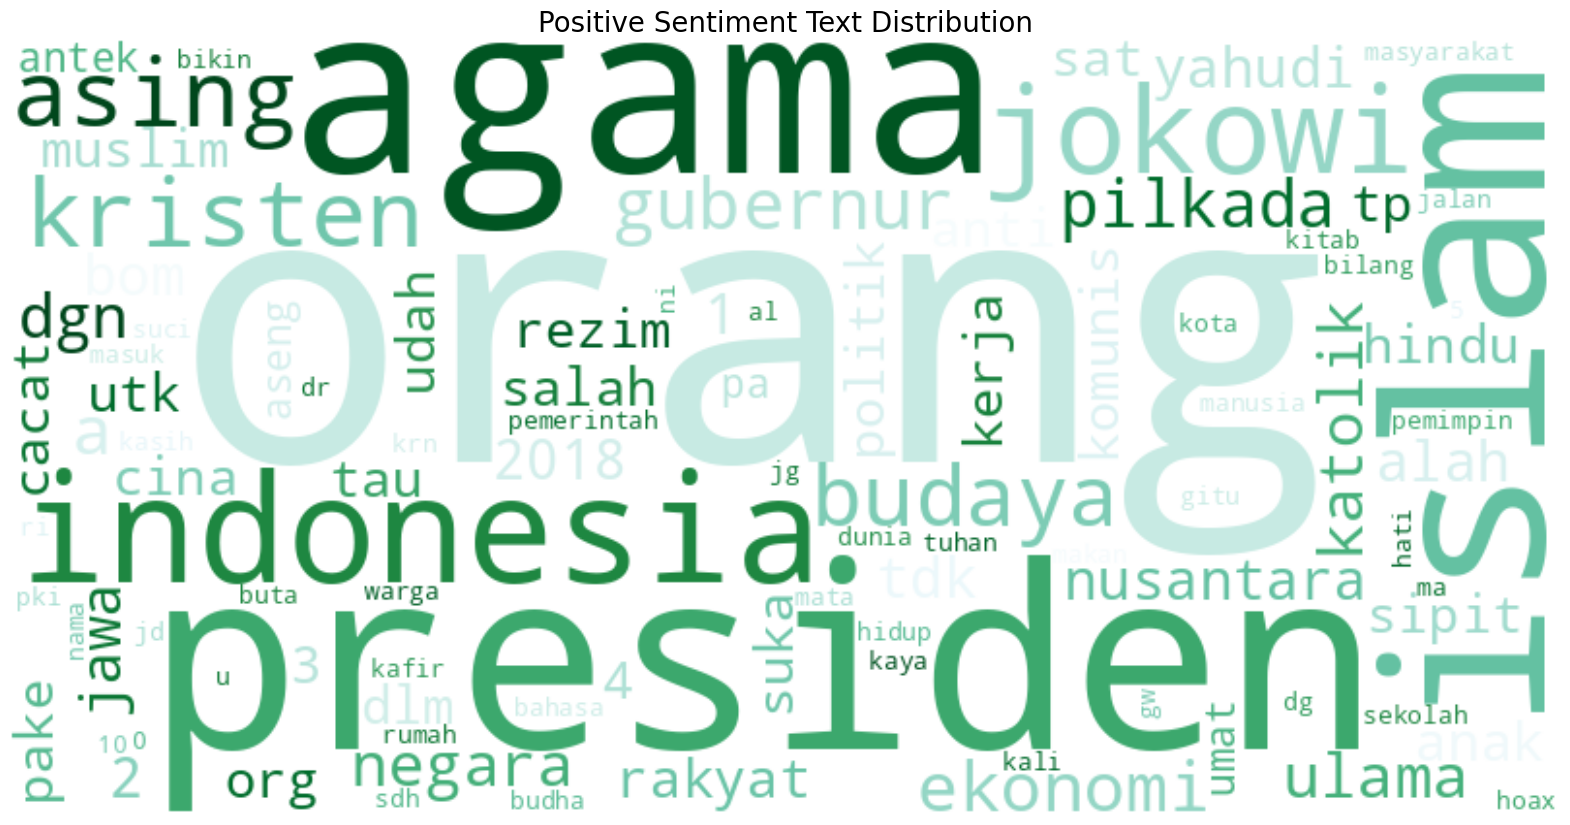

In [26]:
nltk.download('stopwords')
nltk.download('wordnet')

positive_words = preprocess(df1.loc[df1['label'] == 'positive']['text'])
positive_words_df = create_freq_df(positive_words)
top10_positive_words = positive_words_df[:10]

plot_text_distribution(top10_positive_words['Term'], top10_positive_words['Frequency'],
                  'Greens', 'Top 10 Positive Sentiment Text Distribution', 'Text', 'Number of Texts')
create_wordcloud(positive_words_df, 'Positive Sentiment Text Distribution', 'BuGn')

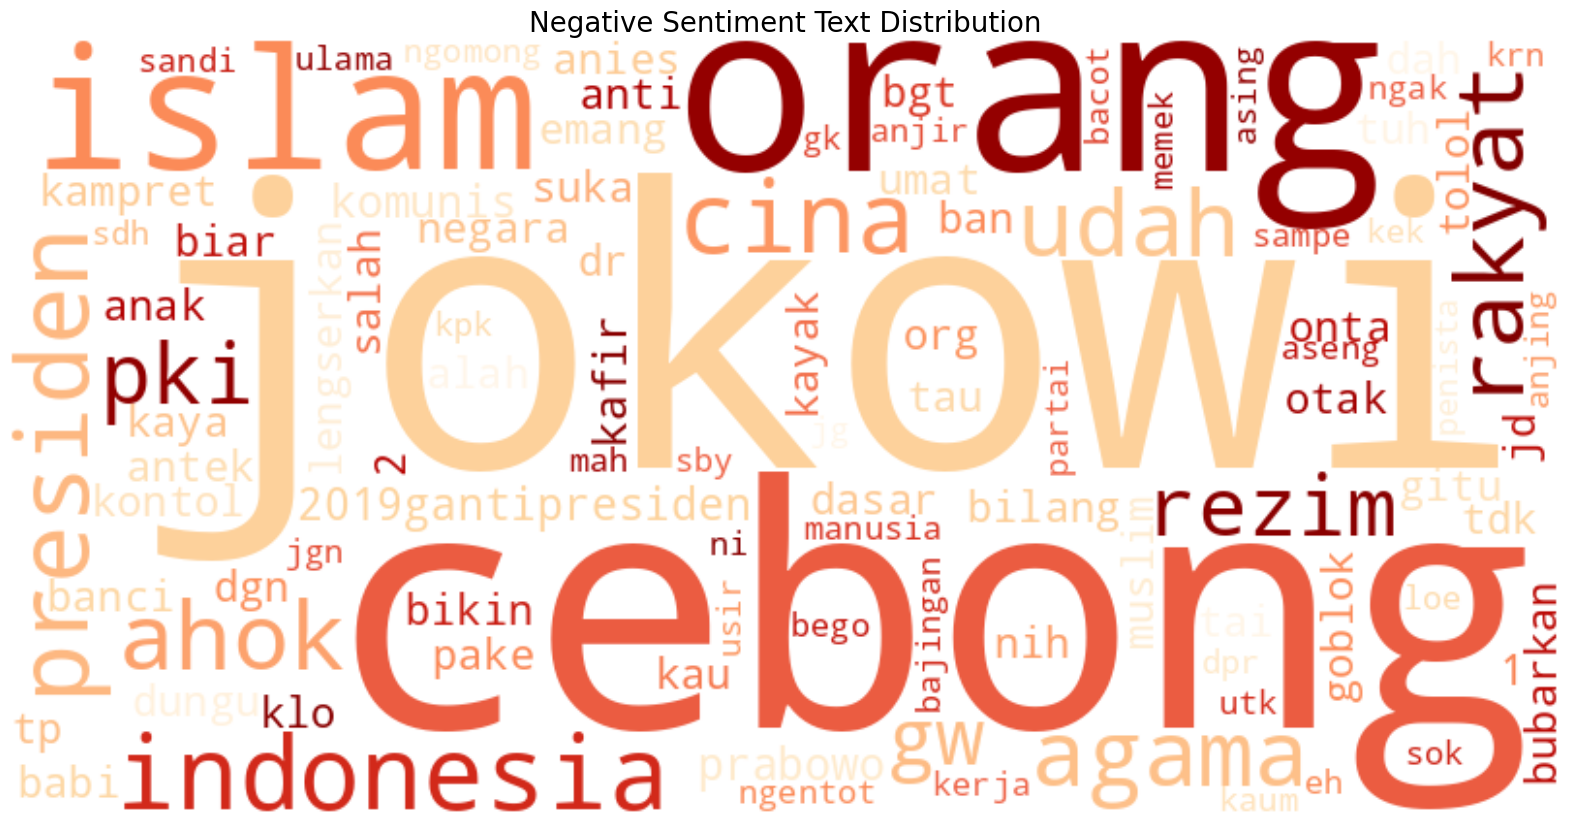

In [27]:
negative_words = preprocess(df1.loc[df1['label'] == 'negative']['text'])
negative_words_df = create_freq_df(negative_words)
top10_negative_words = negative_words_df[:10]

plot_text_distribution(top10_negative_words['Term'], top10_negative_words['Frequency'],
                  'Reds', 'Top 10 Negative Sentiment Text Distribution', 'Text', 'Number of Texts')
create_wordcloud(negative_words_df, 'Negative Sentiment Text Distribution', 'OrRd')

### Dataset Indonlu

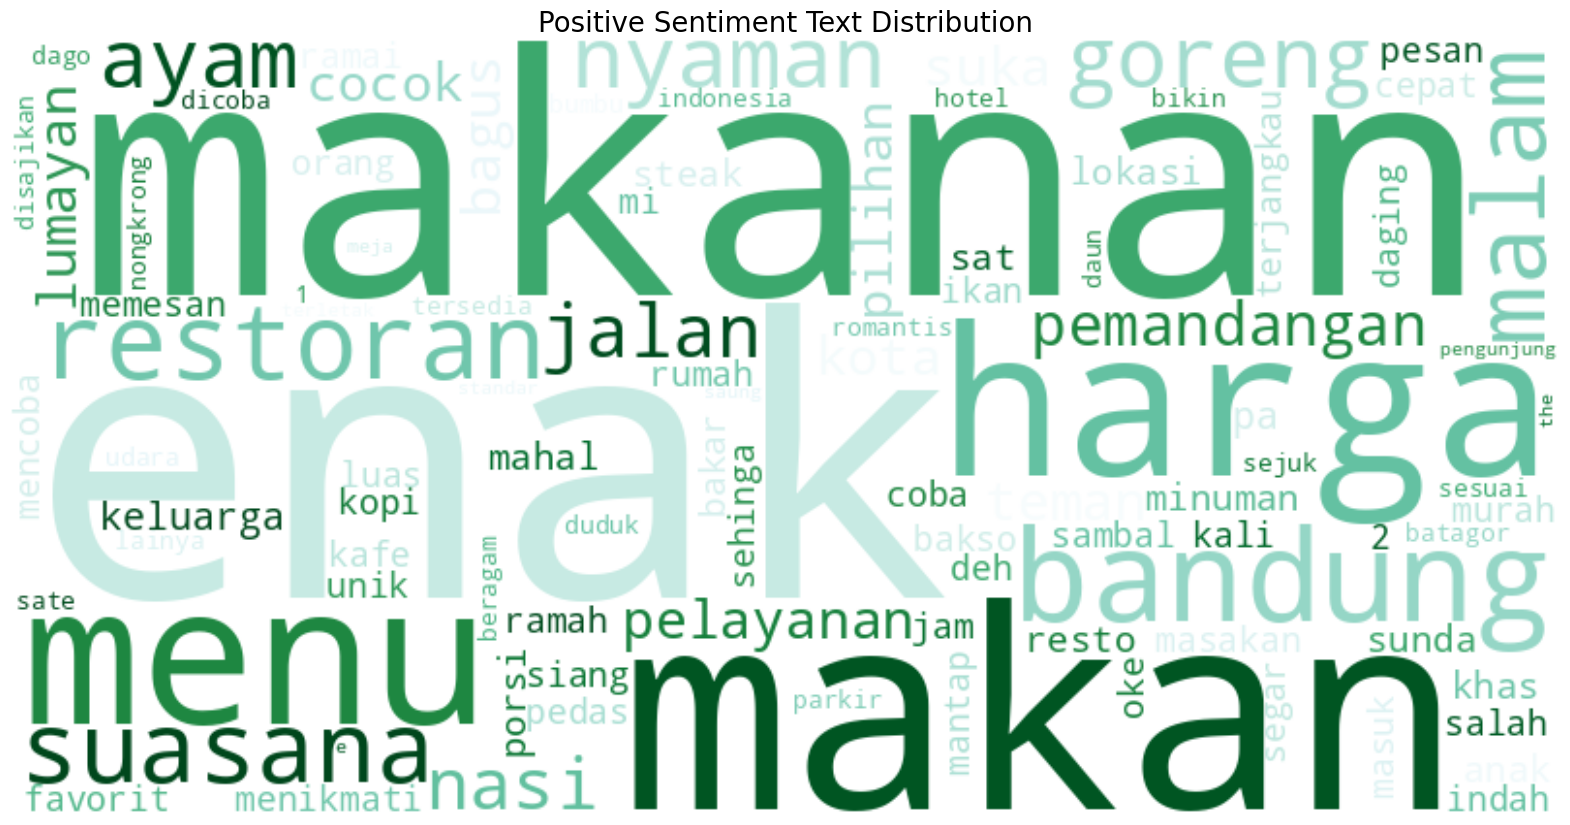

In [28]:
positive_words = preprocess(df2.loc[df2['label'] == 'positive']['text'])
positive_words_df = create_freq_df(positive_words)
top10_positive_words = positive_words_df[:10]

plot_text_distribution(top10_positive_words['Term'], top10_positive_words['Frequency'],
                  'Greens', 'Top 10 Positive Sentiment Text Distribution', 'Text', 'Number of Texts')
create_wordcloud(positive_words_df, 'Positive Sentiment Text Distribution', 'BuGn')

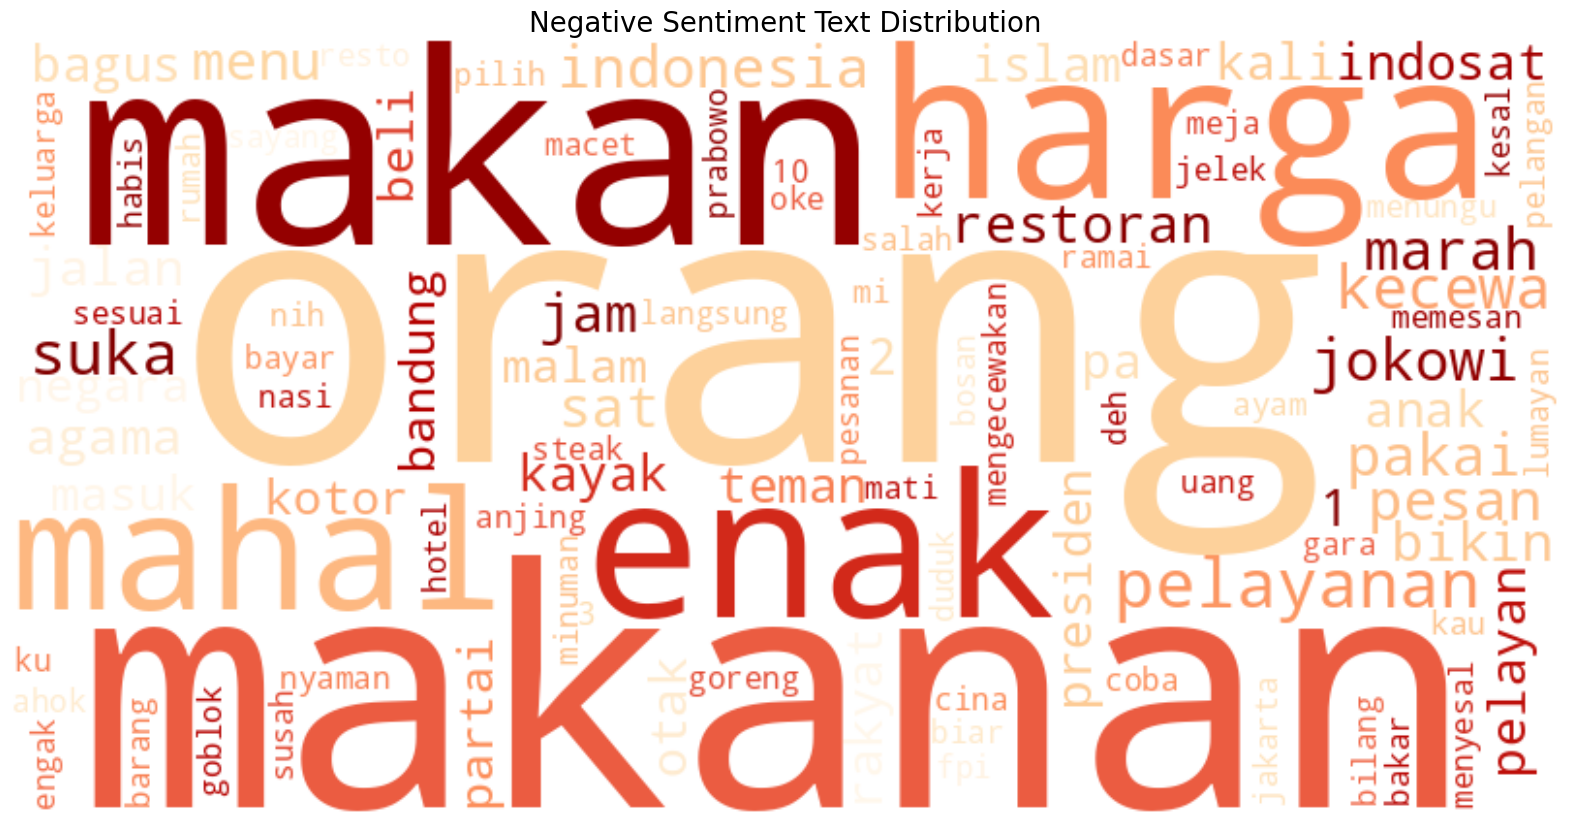

In [29]:
negative_words = preprocess(df2.loc[df2['label'] == 'negative']['text'])
negative_words_df = create_freq_df(negative_words)
top10_negative_words = negative_words_df[:10]

plot_text_distribution(top10_negative_words['Term'], top10_negative_words['Frequency'],
                  'Reds', 'Top 10 Negative Sentiment Text Distribution', 'Text', 'Number of Texts')
create_wordcloud(negative_words_df, 'Negative Sentiment Text Distribution', 'OrRd')

### Dataset Challenge dan Indonlu

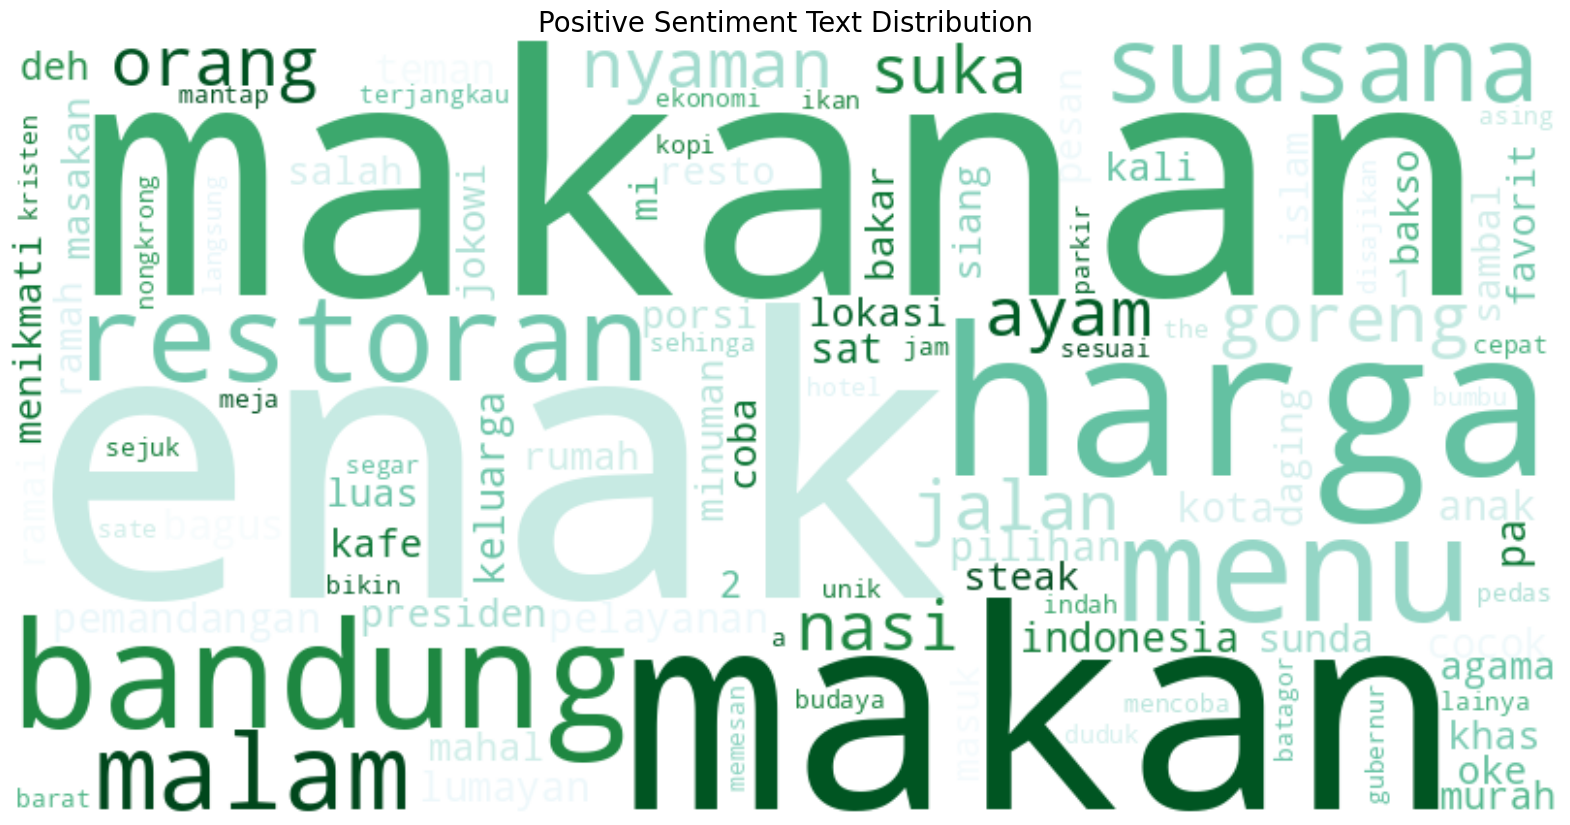

In [30]:
positive_words = preprocess(df3.loc[df3['label'] == 'positive']['text'])
positive_words_df = create_freq_df(positive_words)
top10_positive_words = positive_words_df[:10]

plot_text_distribution(top10_positive_words['Term'], top10_positive_words['Frequency'],
                  'Greens', 'Top 10 Positive Sentiment Text Distribution', 'Text', 'Number of Texts')
create_wordcloud(positive_words_df, 'Positive Sentiment Text Distribution', 'BuGn')

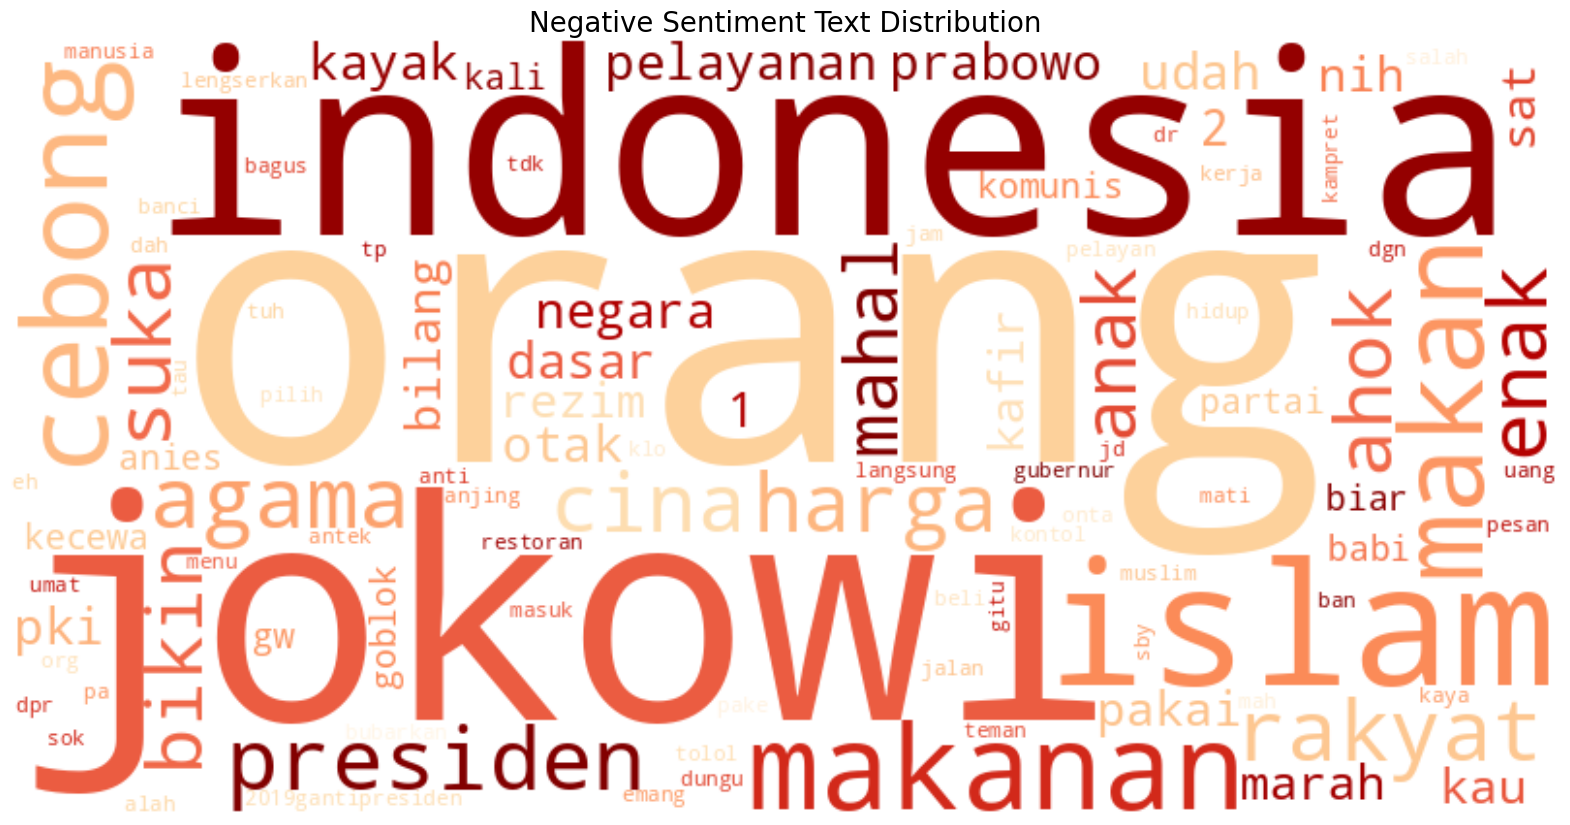

In [31]:
negative_words = preprocess(df3.loc[df3['label'] == 'negative']['text'])
negative_words_df = create_freq_df(negative_words)
top10_negative_words = negative_words_df[:10]

plot_text_distribution(top10_negative_words['Term'], top10_negative_words['Frequency'],
                  'Reds', 'Top 10 Negative Sentiment Text Distribution', 'Text', 'Number of Texts')
create_wordcloud(negative_words_df, 'Negative Sentiment Text Distribution', 'OrRd')

# Data Preprocessing

## Split Dataset

In [32]:
X = df2.text.tolist()
y = df2.label

In [33]:
len(X), y.shape

(11320, (11320,))

## Feature Extraction

In [34]:
#count_vect = TfidfVectorizer()
count_vect = CountVectorizer()

X = count_vect.fit_transform(X)

In [35]:
pickle.dump(count_vect, open("feature.p", "wb"))

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)

In [37]:
X_train.shape, X_test.shape

((9056, 16021), (2264, 16021))

# Modeling

## Simple NN , MLP

In [38]:
#training
from sklearn.neural_network import MLPClassifier

model_mlp = MLPClassifier()
model_mlp.fit(X_train, y_train)

print("Training Selesai !")

Training Selesai !


In [39]:
pickle.dump(model_mlp, open("model.p", "wb"))

In [40]:
#evaluations
from sklearn.metrics import classification_report


test = model_mlp.predict(X_test)

print("Testing Selesai !")

print(classification_report(y_test, test))

Testing Selesai !
              precision    recall  f1-score   support

    negative       0.85      0.84      0.85       857
    positive       0.90      0.91      0.91      1407

    accuracy                           0.89      2264
   macro avg       0.88      0.88      0.88      2264
weighted avg       0.88      0.89      0.89      2264



In [41]:
#predict
original_text = '''
makanan enak

'''

text = count_vect.transform(preprocess(original_text))

if "negative" in model_mlp.predict(text):
  result = "negative"
else:
  result = "positive"

print("Sentiment: ", result)

Sentiment:  positive


## RNN

In [42]:
df2.head()

text  \
0  warung ini dimiliki oleh pengusaha pabrik tahu yang sudah puluhan tahun terkenal membuat tahu putih di bandung tahu berkualitas dipadu keahlian memasak dipadu kretivitas jadilah warung yang menyajikan menu utama berbahan tahu ditambah menu umum lain seperti ayam semuanya selera indonesia harga cukup terjangkau jangan lewatkan tahu bletoka nya tidak kalah dengan yang asli dari tegal   
2                                                                                                                                                                                                                      lokasi strategis di jalan sumatera bandung tempat nya nyaman terutama sofa di lantai 2 paela nya enak sangat pas dimakan dengan minum bir dingin apetiser nya juga enak enak   
3                                                                                                                                                                                                                                                                                                          betapa bahagia nya diri ini sat unboxing paket dan barang nya bagus menetapkan beli lagi   
4                                                                                                                                                                                          duh jadi mahasiswa jangan sombong dong kasih kartu kuning segala belajar dulu yang baik tidak usahlah ikut ikut politik nanti sudah selesai kuliah nya mau ikut politik juga tidak telat dasar mahasiswa   
5                                                                                                                                                                                                                                           makanan beragam harga makanan di fod stal akan ditambahkan 10 lagi di kasir suasana ramai dan perlu perhatian untuk mendapatkan parkir dan tempat duduk   

      label  
0  positive  
2  positive  
3  positive  
4  negative  
5  positive

In [43]:
df2.label.value_counts()

positive    7316
negative    4004
Name: label, dtype: int64

In [44]:
neg = df2.loc[df2['label']=='negative'].text.tolist()
pos = df2.loc[df2['label']=='positive'].text.tolist()
net = df2.loc[df2['label']=='neutral'].text.tolist()


neg_label = df2.loc[df2['label']=='negative'].label.tolist()
pos_label = df2.loc[df2['label']=='positive'].label.tolist()
net_label = df2.loc[df2['label']=='neutral'].label.tolist()

total_data = pos+neg+net
labels = pos_label+neg_label + net_label

In [45]:
len(total_data), len(labels)

(11320, 11320)

In [46]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split= ' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle','wb') as handle:
  pickle.dump(tokenizer, handle, protocol= pickle.HIGHEST_PROTOCOL)
  print("tokenizer.pickle has created !")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle','wb') as handle:
  pickle.dump(X, handle, protocol = pickle.HIGHEST_PROTOCOL)
  print('x_pad_sequences.pickle has created !')

tokenizer.pickle has created !
x_pad_sequences.pickle has created !


In [47]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle','wb') as handle:
  pickle.dump(Y, handle, protocol = pickle.HIGHEST_PROTOCOL)
  print('y_labels.pickle has created !')

y_labels.pickle has created !


In [48]:
from sklearn.model_selection import train_test_split

file = open('x_pad_sequences.pickle','rb')
X = pickle.load(file)
file.close()

file = open('y_labels.pickle','rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size= 0.2, random_state=1)

In [49]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(9056, 96) (9056, 2) (2264, 96) (2264, 2)


In [52]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, random_state=42, shuffle=True)
accuracies = []
precisions = []
recalls = []

y = Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start=1):
    data_train = X[data[0]]
    target_train = y[data[0]]

    data_test = X[data[1]]
    target_test = y[data[1]]

    model_rnn = Sequential()
    model_rnn.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model_rnn.add(SimpleRNN(units, dropout=0.5))
    model_rnn.add(Dense(2, activation='softmax'))
    sgd = optimizers.Adam(lr=0.001)
    model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
    history_rnn = model_rnn.fit(data_train, target_train, epochs=10, batch_size=10, validation_data=(data_test, target_test), verbose=1, callbacks=[es])

    predictions = model_rnn.predict(data_test)
    y_pred = predictions

    accuracy = accuracy_score(target_test.argmax(axis=1), y_pred.argmax(axis=1))
    precision = precision_score(target_test.argmax(axis=1), y_pred.argmax(axis=1))
    recall = recall_score(target_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(target_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("============================================================")

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)

average_accuracy = np.mean(accuracies)
average_precision = np.mean(precisions)
average_recall = np.mean(recalls)

print("Rata-rata Accuracy: ", average_accuracy)
print("Rata-rata Precision: ", average_precision)
print("Rata-rata Recall: ", average_recall)


Epoch 1/10
906/906 [==============================] - 156s 167ms/step - loss: 0.3528 - accuracy: 0.8521 - val_loss: 0.2505 - val_accuracy: 0.8989
Epoch 2/10
906/906 [==============================] - 129s 142ms/step - loss: 0.1912 - accuracy: 0.9256 - val_loss: 0.2443 - val_accuracy: 0.9055
Epoch 3/10
906/906 [==============================] - 123s 135ms/step - loss: 0.1329 - accuracy: 0.9481 - val_loss: 0.2766 - val_accuracy: 0.8900
Epoch 4/10
906/906 [==============================] - 123s 135ms/step - loss: 0.0828 - accuracy: 0.9672 - val_loss: 0.3245 - val_accuracy: 0.8807
Epoch 5/10
906/906 [==============================] - 126s 139ms/step - loss: 0.0608 - accuracy: 0.9752 - val_loss: 0.3693 - val_accuracy: 0.8825
Epoch 6/10
906/906 [==============================] - 125s 138ms/step - loss: 0.0506 - accuracy: 0.9766 - val_loss: 0.4003 - val_accuracy: 0.8790
Epoch 7/10
906/906 [==============================] - 124s 137ms/step - loss: 0.0393 - accuracy: 0.9820 - val_loss: 0.4538 -

Epoch 1/10
906/906 [==============================] - 144s 157ms/step - loss: 0.3727 - accuracy: 0.8408 - val_loss: 0.2955 - val_accuracy: 0.8781
Epoch 2/10
906/906 [==============================] - 123s 136ms/step - loss: 0.1937 - accuracy: 0.9246 - val_loss: 0.2654 - val_accuracy: 0.9028
Epoch 3/10
906/906 [==============================] - 118s 130ms/step - loss: 0.1238 - accuracy: 0.9500 - val_loss: 0.2753 - val_accuracy: 0.8785
Epoch 4/10
906/906 [==============================] - 120s 133ms/step - loss: 0.0953 - accuracy: 0.9625 - val_loss: 0.2745 - val_accuracy: 0.8971
Epoch 5/10
906/906 [==============================] - 117s 129ms/step - loss: 0.0694 - accuracy: 0.9721 - val_loss: 0.3393 - val_accuracy: 0.8909
Epoch 6/10
906/906 [==============================] - 121s 133ms/step - loss: 0.0546 - accuracy: 0.9766 - val_loss: 0.3892 - val_accuracy: 0.8799
Epoch 7/10
906/906 [==============================] - 115s 127ms/step - loss: 0.0441 - accuracy: 0.9803 - val_loss: 0.4085 -

Epoch 1/10
906/906 [==============================] - 144s 157ms/step - loss: 0.3385 - accuracy: 0.8580 - val_loss: 0.2618 - val_accuracy: 0.8966
Epoch 2/10
906/906 [==============================] - 118s 131ms/step - loss: 0.1880 - accuracy: 0.9280 - val_loss: 0.2622 - val_accuracy: 0.8931
Epoch 3/10
906/906 [==============================] - 121s 133ms/step - loss: 0.1297 - accuracy: 0.9500 - val_loss: 0.3184 - val_accuracy: 0.8684
Epoch 4/10
906/906 [==============================] - 116s 129ms/step - loss: 0.0835 - accuracy: 0.9680 - val_loss: 0.3172 - val_accuracy: 0.8777
Epoch 5/10
906/906 [==============================] - 119s 131ms/step - loss: 0.0996 - accuracy: 0.9625 - val_loss: 0.3459 - val_accuracy: 0.8790
Epoch 6/10
906/906 [==============================] - 115s 127ms/step - loss: 0.0765 - accuracy: 0.9715 - val_loss: 0.3739 - val_accuracy: 0.8679
Epoch 6: early stopping
71/71 [==============================] - 1s 8ms/step


Training ke- 3
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       807
           1       0.89      0.90      0.90      1457

    accuracy                           0.87      2264
   macro avg       0.86      0.85      0.86      2264
weighted avg       0.87      0.87      0.87      2264

Epoch 1/10
906/906 [==============================] - 148s 162ms/step - loss: 0.3836 - accuracy: 0.8306 - val_loss: 0.2917 - val_accuracy: 0.8852
Epoch 2/10
906/906 [==============================] - 125s 138ms/step - loss: 0.2024 - accuracy: 0.9252 - val_loss: 0.2569 - val_accuracy: 0.8971
Epoch 3/10
906/906 [==============================] - 121s 133ms/step - loss: 0.1623 - accuracy: 0.9387 - val_loss: 0.2650 - val_accuracy: 0.8953
Epoch 4/10
906/906 [==============================] - 123s 135ms/step - loss: 0.1057 - accuracy: 0.9599 - val_loss: 0.2940 - val_accuracy: 0.8878
Epoch 5/10
906/906 [==============================] - 130s 144ms/step - lo

Training ke- 4
              precision    recall  f1-score   support

           0       0.81      0.82      0.82       821
           1       0.90      0.89      0.90      1443

    accuracy                           0.87      2264
   macro avg       0.86      0.86      0.86      2264
weighted avg       0.87      0.87      0.87      2264

Epoch 1/10
906/906 [==============================] - 145s 158ms/step - loss: 0.3422 - accuracy: 0.8572 - val_loss: 0.2646 - val_accuracy: 0.8909
Epoch 2/10
906/906 [==============================] - 124s 137ms/step - loss: 0.1855 - accuracy: 0.9282 - val_loss: 0.2745 - val_accuracy: 0.8984
Epoch 3/10
906/906 [==============================] - 123s 136ms/step - loss: 0.1231 - accuracy: 0.9519 - val_loss: 0.3023 - val_accuracy: 0.8785
Epoch 4/10
906/906 [==============================] - 119s 131ms/step - loss: 0.0790 - accuracy: 0.9676 - val_loss: 0.3582 - val_accuracy: 0.8883
Epoch 5/10
906/906 [==============================] - 123s 136ms/step - lo

In [53]:
model_rnn.save('model_rnn.h5')
print("Model has Creqated !")

Model has Creqated !


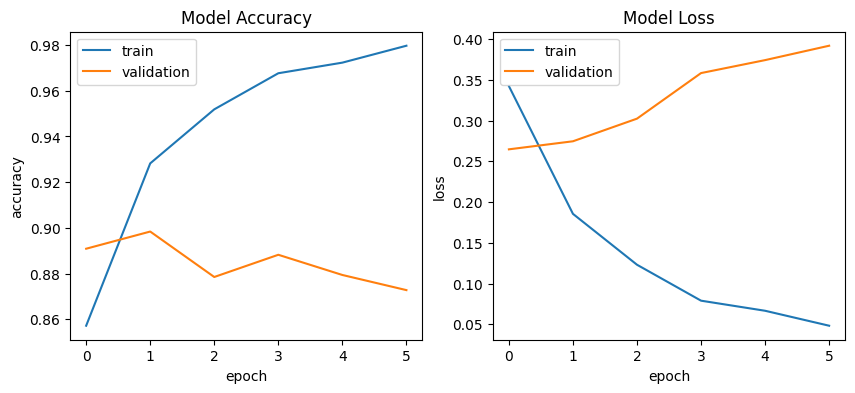

In [54]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''

    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')

plot_training_hist(history_rnn)

In [74]:
#prediction
import re
from keras.models import load_model
input_text = '''
produknya kacau
'''
sentiment = ['positive','negative']

text = [input_text]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])
print(predicted, guess)
model = load_model('/content/model_rnn.h5')
prediction= model.predict(guess)
polarity = np.argmax(prediction)

print("Text: ", text[0])
print("Sentiment: ", sentiment[polarity])

[[1469]] [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0 1469]]
1/1 [==============================] - 0s 254ms/step
Text:  
produknya kacau

Sentiment:  positive


## LSTM

In [60]:
neg = df2.loc[df2['label']=='negative'].text.tolist()
pos = df2.loc[df2['label']=='positive'].text.tolist()
net = df2.loc[df2['label']=='neutral'].text.tolist()


neg_label = df2.loc[df2['label']=='negative'].label.tolist()
pos_label = df2.loc[df2['label']=='positive'].label.tolist()
net_label = df2.loc[df2['label']=='neutral'].label.tolist()

total_data = pos+neg+net
labels = pos_label+neg_label + net_label

In [61]:
len(total_data), len(labels)

(11320, 11320)

In [62]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split= ' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle','wb') as handle:
  pickle.dump(tokenizer, handle, protocol= pickle.HIGHEST_PROTOCOL)
  print("tokenizer.pickle has created !")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle','wb') as handle:
  pickle.dump(X, handle, protocol = pickle.HIGHEST_PROTOCOL)
  print('x_pad_sequences.pickle has created !')

tokenizer.pickle has created !
x_pad_sequences.pickle has created !


In [63]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle','wb') as handle:
  pickle.dump(Y, handle, protocol = pickle.HIGHEST_PROTOCOL)
  print('y_labels.pickle has created !')

y_labels.pickle has created !


In [64]:
from sklearn.model_selection import train_test_split

file = open('x_pad_sequences.pickle','rb')
X = pickle.load(file)
file.close()

file = open('y_labels.pickle','rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size= 0.2, random_state=1)

In [65]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(9056, 96) (9056, 2) (2264, 96) (2264, 2)


In [66]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from keras.optimizers.legacy import SGD
from keras.optimizers import RMSprop
from keras import datasets
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History
from sklearn.model_selection import KFold
from keras import losses
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score

kf = KFold(n_splits=5, random_state=42, shuffle=True)
accuracies = []
precisions = []
recalls = []

y = Y

for iteration, data in enumerate(kf.split(X), start=1):
    data_train = X[data[0]]
    target_train = y[data[0]]

    data_test = X[data[1]]
    target_test = y[data[1]]

    vocab_size = 5000
    embedding_size = 32
    epochs = 20
    learning_rate = 0.1
    decay_rate = learning_rate / epochs
    momentum = 0.8

    sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

    # Build model
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_size, input_length=X.shape[1]))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dropout(0.4))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=sgd,
                  metrics=['accuracy', Precision(), Recall()])

    # Train model
    batch_size = 16
    es = EarlyStopping(monitor='val_loss', mode='main', verbose=1)
    history_lstm = model.fit(data_train, target_train,
                        validation_data=(data_test, target_test),
                        batch_size=batch_size, epochs=epochs, verbose=1)

    predictions = model.predict(data_test)
    y_pred = predictions

    accuracy = accuracy_score(target_test.argmax(axis=1), y_pred.argmax(axis=1))
    precision = precision_score(target_test.argmax(axis=1), y_pred.argmax(axis=1))
    recall = recall_score(target_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(target_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("============================================================")

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)

average_accuracy = np.mean(accuracies)
average_precision = np.mean(precisions)
average_recall = np.mean(recalls)

print("Rata-rata Accuracy: ", average_accuracy)
print("Rata-rata Precision: ", average_precision)
print("Rata-rata Recall: ", average_recall)


Epoch 1/20
566/566 [==============================] - 16s 11ms/step - loss: 0.4595 - accuracy: 0.7868 - precision: 0.7868 - recall: 0.7868 - val_loss: 0.3050 - val_accuracy: 0.8763 - val_precision: 0.8763 - val_recall: 0.8763
Epoch 2/20
566/566 [==============================] - 6s 10ms/step - loss: 0.2909 - accuracy: 0.8821 - precision: 0.8821 - recall: 0.8821 - val_loss: 0.2675 - val_accuracy: 0.8843 - val_precision: 0.8843 - val_recall: 0.8843
Epoch 3/20
566/566 [==============================] - 5s 9ms/step - loss: 0.2286 - accuracy: 0.9097 - precision: 0.9097 - recall: 0.9097 - val_loss: 0.2761 - val_accuracy: 0.8869 - val_precision: 0.8869 - val_recall: 0.8869
Epoch 4/20
566/566 [==============================] - 6s 11ms/step - loss: 0.1940 - accuracy: 0.9210 - precision: 0.9210 - recall: 0.9210 - val_loss: 0.2351 - val_accuracy: 0.8993 - val_precision: 0.8993 - val_recall: 0.8993
Epoch 5/20
566/566 [==============================] - 5s 9ms/step - loss: 0.1694 - accuracy: 0.9335 

71/71 [==============================] - 1s 4ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       774
           1       0.93      0.93      0.93      1490

    accuracy                           0.91      2264
   macro avg       0.89      0.90      0.89      2264
weighted avg       0.91      0.91      0.91      2264



Epoch 1/20
566/566 [==============================] - 10s 13ms/step - loss: 0.4948 - accuracy: 0.7699 - precision_1: 0.7699 - recall_1: 0.7699 - val_loss: 0.3414 - val_accuracy: 0.8529 - val_precision_1: 0.8529 - val_recall_1: 0.8529
Epoch 2/20
566/566 [==============================] - 5s 9ms/step - loss: 0.3083 - accuracy: 0.8769 - precision_1: 0.8769 - recall_1: 0.8769 - val_loss: 0.2824 - val_accuracy: 0.8794 - val_precision_1: 0.8794 - val_recall_1: 0.8794
Epoch 3/20
566/566 [==============================] - 6s 11ms/step - loss: 0.2384 - accuracy: 0.9077 - precision_1: 0.9077 - recall_1: 0.9077 - val_loss: 0.2451 - val_accuracy: 0.8993 - val_precision_1: 0.8993 - val_recall_1: 0.8993
Epoch 4/20
566/566 [==============================] - 6s 10ms/step - loss: 0.2053 - accuracy: 0.9193 - precision_1: 0.9193 - recall_1: 0.9193 - val_loss: 0.2414 - val_accuracy: 0.9037 - val_precision_1: 0.9037 - val_recall_1: 0.9037
Epoch 5/20
566/566 [==============================] - 7s 12ms/step -

Epoch 1/20
566/566 [==============================] - 10s 13ms/step - loss: 0.4614 - accuracy: 0.7883 - precision_2: 0.7883 - recall_2: 0.7883 - val_loss: 0.3556 - val_accuracy: 0.8366 - val_precision_2: 0.8366 - val_recall_2: 0.8366
Epoch 2/20
566/566 [==============================] - 5s 9ms/step - loss: 0.2927 - accuracy: 0.8803 - precision_2: 0.8803 - recall_2: 0.8803 - val_loss: 0.2760 - val_accuracy: 0.8830 - val_precision_2: 0.8830 - val_recall_2: 0.8830
Epoch 3/20
566/566 [==============================] - 6s 10ms/step - loss: 0.2336 - accuracy: 0.9036 - precision_2: 0.9036 - recall_2: 0.9036 - val_loss: 0.2541 - val_accuracy: 0.8975 - val_precision_2: 0.8975 - val_recall_2: 0.8975
Epoch 4/20
566/566 [==============================] - 5s 10ms/step - loss: 0.2009 - accuracy: 0.9187 - precision_2: 0.9187 - recall_2: 0.9187 - val_loss: 0.2480 - val_accuracy: 0.8953 - val_precision_2: 0.8953 - val_recall_2: 0.8953
Epoch 5/20
566/566 [==============================] - 5s 9ms/step - 

Epoch 1/20
566/566 [==============================] - 9s 11ms/step - loss: 0.4527 - accuracy: 0.7930 - precision_3: 0.7930 - recall_3: 0.7930 - val_loss: 0.3287 - val_accuracy: 0.8609 - val_precision_3: 0.8609 - val_recall_3: 0.8609
Epoch 2/20
566/566 [==============================] - 6s 11ms/step - loss: 0.2851 - accuracy: 0.8853 - precision_3: 0.8853 - recall_3: 0.8853 - val_loss: 0.2849 - val_accuracy: 0.8794 - val_precision_3: 0.8794 - val_recall_3: 0.8794
Epoch 3/20
566/566 [==============================] - 5s 9ms/step - loss: 0.2232 - accuracy: 0.9107 - precision_3: 0.9107 - recall_3: 0.9107 - val_loss: 0.2524 - val_accuracy: 0.8971 - val_precision_3: 0.8971 - val_recall_3: 0.8971
Epoch 4/20
566/566 [==============================] - 5s 9ms/step - loss: 0.1949 - accuracy: 0.9256 - precision_3: 0.9256 - recall_3: 0.9256 - val_loss: 0.2396 - val_accuracy: 0.9068 - val_precision_3: 0.9068 - val_recall_3: 0.9068
Epoch 5/20
566/566 [==============================] - 6s 10ms/step - l

Epoch 1/20
566/566 [==============================] - 13s 18ms/step - loss: 0.4717 - accuracy: 0.7836 - precision_4: 0.7836 - recall_4: 0.7836 - val_loss: 0.3656 - val_accuracy: 0.8525 - val_precision_4: 0.8525 - val_recall_4: 0.8525
Epoch 2/20
566/566 [==============================] - 5s 10ms/step - loss: 0.2983 - accuracy: 0.8815 - precision_4: 0.8815 - recall_4: 0.8815 - val_loss: 0.2679 - val_accuracy: 0.8887 - val_precision_4: 0.8887 - val_recall_4: 0.8887
Epoch 3/20
566/566 [==============================] - 7s 12ms/step - loss: 0.2372 - accuracy: 0.9046 - precision_4: 0.9046 - recall_4: 0.9046 - val_loss: 0.2432 - val_accuracy: 0.9033 - val_precision_4: 0.9033 - val_recall_4: 0.9033
Epoch 4/20
566/566 [==============================] - 5s 9ms/step - loss: 0.2031 - accuracy: 0.9252 - precision_4: 0.9252 - recall_4: 0.9252 - val_loss: 0.2361 - val_accuracy: 0.9024 - val_precision_4: 0.9024 - val_recall_4: 0.9024
Epoch 5/20
566/566 [==============================] - 6s 11ms/step -

In [68]:
model.save('model_lstm.h5')
print("Model has Creqated !")

Model has Creqated !


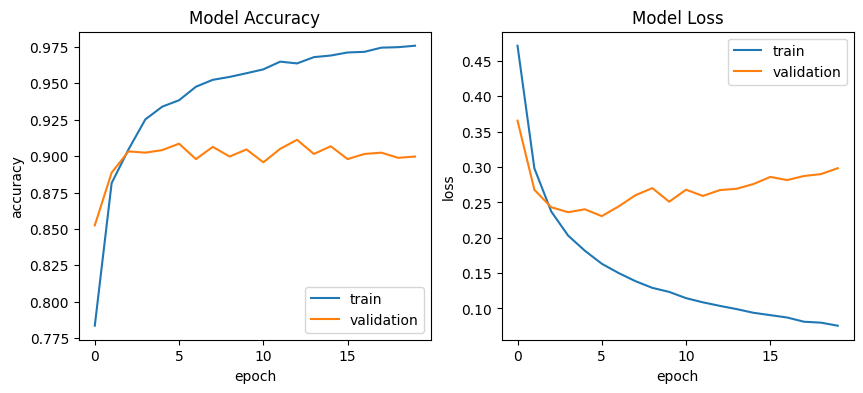

In [69]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''

    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')

plot_training_hist(history_lstm)

In [75]:
model.save('best_model.h5')
print('Best model saved')

Best model saved


In [77]:
#prediction
import re
from keras.models import load_model
input_text = '''
tempatnya kotor
'''
sentiment = ['negative','positive']

text = [input_text]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])
print(predicted, guess)
model = load_model('/content/best_model.h5')
prediction= model.predict(guess)
polarity = np.argmax(prediction)

print("Text: ", text[0])
print("Sentiment: ", sentiment[polarity])

[[434]] [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0 434]]
1/1 [==============================] - 1s 515ms/step
Text:  
tempatnya kotor

Sentiment:  negative
